In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

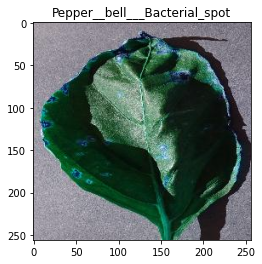

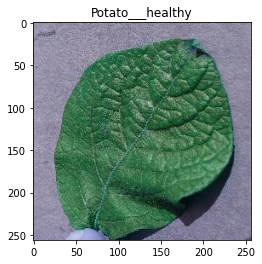

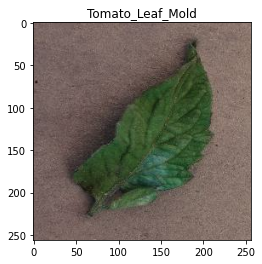

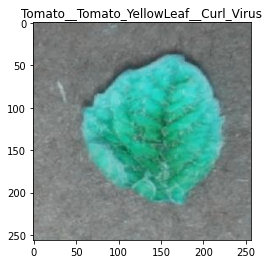

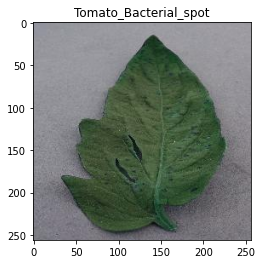

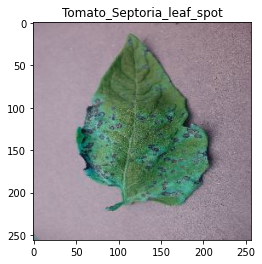

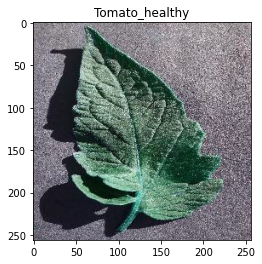

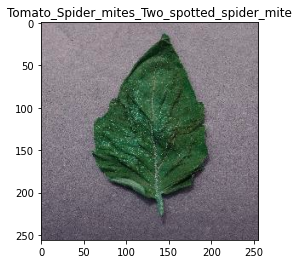

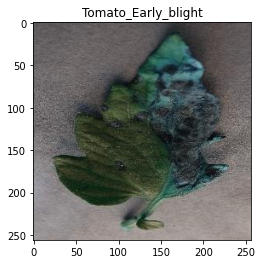

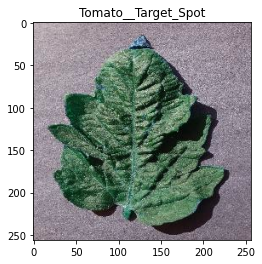

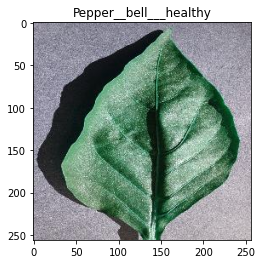

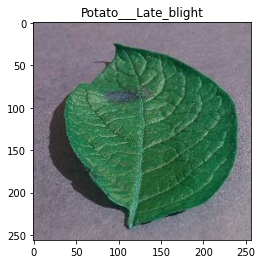

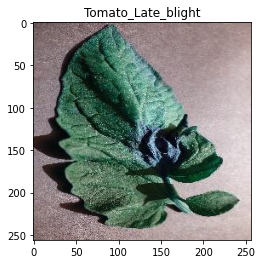

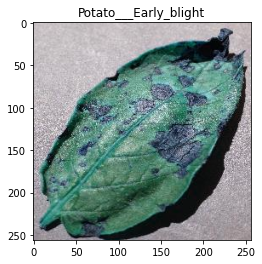

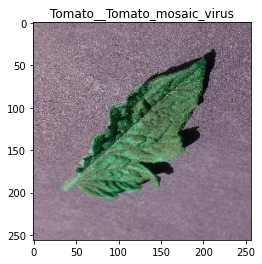

In [2]:
DATA_PATH = '../input/plantdisease/PlantVillage'    # dataset link "https://www.kaggle.com/datasets/emmarex/plantdisease"

for cat in os.listdir(DATA_PATH):
    path = os.path.join(DATA_PATH, cat)
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path, img), cv2.IMREAD_UNCHANGED)
        plt.imshow(image)
        plt.title(f'{cat}')
        plt.show()
        break

## Preprocessing

In [3]:
IMG_SHAPE = (224, 224)
INPUT_SHAPE = [224, 224, 3]
EPOCHS = 10
BS = 32

In [4]:
img_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, horizontal_flip=True, vertical_flip=True,
                                 shear_range=0.2, validation_split=0.25)

train_data_gen = img_data_gen.flow_from_directory(DATA_PATH, batch_size=BS, subset='training', 
                                                  class_mode='categorical', shuffle=True) 

val_data_gen = img_data_gen.flow_from_directory(DATA_PATH, batch_size=BS, subset='validation', 
                                                  class_mode='categorical', shuffle=True) 

Found 15482 images belonging to 15 classes.
Found 5156 images belonging to 15 classes.


In [5]:
label = train_data_gen.class_indices
label

{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

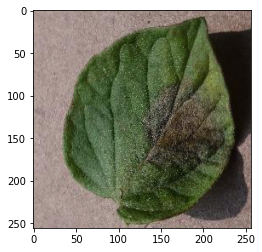

In [6]:
img = train_data_gen.__getitem__(11)[0]
plt.imshow(img[0])
#plt.title(label[11])

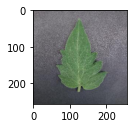

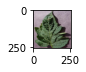

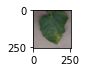

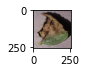

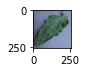

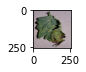

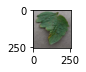

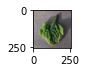

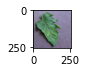

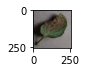

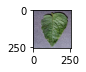

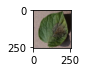

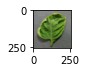

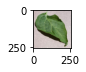

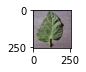

In [7]:
plt.figure(figsize=(16,10))
for i in range(15):
    plt.subplot(5, 3, i+1)
    img = train_data_gen.__getitem__(i)[0]
    plt.imshow(img[0])
    plt.xticks()
    plt.show()

## Model Building

In [8]:
def model_building(model_name, INPUT_SHAPE=INPUT_SHAPE):
    print('Model Initialization started')
    base_model = model_name(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    
    for layers in base_model.layers:
        layers.trainable = False
    print('Model Initialization finished')
    
    #model creation
    print('Model creation started')
    inp_model = base_model.output
    
    x = GlobalAveragePooling2D()(inp_model)
    x = Dense(128, activation = 'relu')(x)
    x = Dense(15, activation = 'sigmoid')(x)
    
    model = Model(inputs = base_model.input, outputs = x)
    
    #model summary
    print('Model summary')
    #model.summary()
    
    #model compilation
    model.compile(optimizer = 'adam', metrics=['accuracy'], loss = 'categorical_crossentropy')
    
    history = model.fit(train_data_gen, validation_data=val_data_gen, 
                       validation_steps=len(val_data_gen)//BS,
                       steps_per_epoch=len(train_data_gen)//BS,
                       batch_size=BS, 
                       epochs=EPOCHS)
    
    print('Model Building Finished')
    
    !mkdir -p saved_model
    model.save(f'saved_model/{model_name}_1.h5')
    print('Model was saved')
    
    return history

In [9]:
def evaluation_plot(model):
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(10, 8))
    plt.plot(model['loss'], label = 'loss')
    plt.plot(model['accuracy'], label = 'accuracy')
    plt.plot(model['val_loss'], label = 'val_loss')
    plt.plot(model['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.title('Model Evaluation')
    plt.show()

#### VGG16 Model

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

In [11]:
vgg16_hist = model_building(VGG16)

Model Initialization started


2022-10-24 03:24:00.024409: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58900480/58889256 [==============================] - 0s 0us/step
Model Initialization finished
Model creation started
Model summary


2022-10-24 03:24:01.752300: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
15/15 [==============================] - 224s 15s/step - loss: 2.5469 - accuracy: 0.2083 - val_loss: 2.5000 - val_accuracy: 0.2000
Epoch 2/10
15/15 [==============================] - 223s 15s/step - loss: 2.4642 - accuracy: 0.1792 - val_loss: 2.4385 - val_accuracy: 0.2937
Epoch 3/10
15/15 [==============================] - 222s 15s/step - loss: 2.3735 - accuracy: 0.2688 - val_loss: 2.3429 - val_accuracy: 0.2688
Epoch 4/10
15/15 [==============================] - 221s 15s/step - loss: 2.2568 - accuracy: 0.3375 - val_loss: 2.2376 - val_accuracy: 0.4313
Epoch 5/10
15/15 [==============================] - 219s 15s/step - loss: 2.1448 - accuracy: 0.3417 - val_loss: 2.1834 - val_accuracy: 0.3625
Epoch 6/10
15/15 [==============================] - 217s 15s/step - loss: 2.0624 - accuracy: 0.4583 - val_loss: 2.0748 - val_accuracy: 0.4062
Epoch 7/10
15/15 [==============================] - 217s 15s/step - loss: 2.0255 - accuracy: 0.4458 - val_loss: 1.9207 - val_accuracy: 0.4563
Epoch 

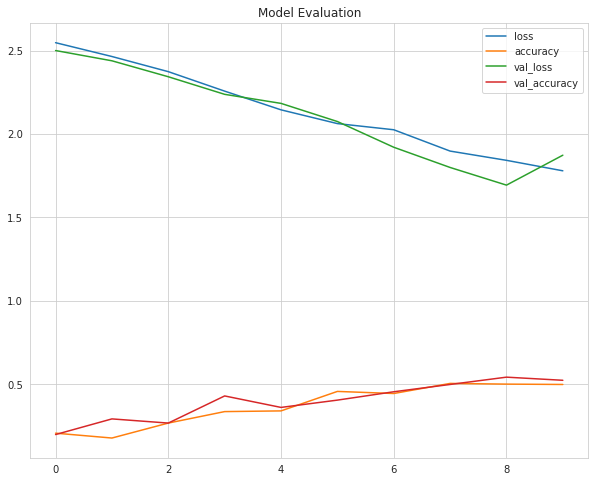

In [12]:
evaluation_plot(vgg16_hist.history)

#### Inception v3 model

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [14]:
inc_history = model_building(InceptionV3)

Model Initialization started
87924736/87910968 [==============================] - 0s 0us/step
Model Initialization finished
Model creation started
Model summary
Epoch 1/10
15/15 [==============================] - 58s 4s/step - loss: 2.3126 - accuracy: 0.2854 - val_loss: 2.0934 - val_accuracy: 0.3875
Epoch 2/10
15/15 [==============================] - 50s 3s/step - loss: 1.8038 - accuracy: 0.4521 - val_loss: 1.6144 - val_accuracy: 0.5188
Epoch 3/10
15/15 [==============================] - 50s 3s/step - loss: 1.4681 - accuracy: 0.5604 - val_loss: 1.3108 - val_accuracy: 0.6375
Epoch 4/10
15/15 [==============================] - 50s 3s/step - loss: 1.3854 - accuracy: 0.5938 - val_loss: 1.2019 - val_accuracy: 0.6500
Epoch 5/10
15/15 [==============================] - 50s 3s/step - loss: 1.1868 - accuracy: 0.6354 - val_loss: 1.2017 - val_accuracy: 0.5938
Epoch 6/10
15/15 [==============================] - 50s 3s/step - loss: 1.1274 - accuracy: 0.6104 - val_loss: 1.0002 - val_accuracy: 0.6812

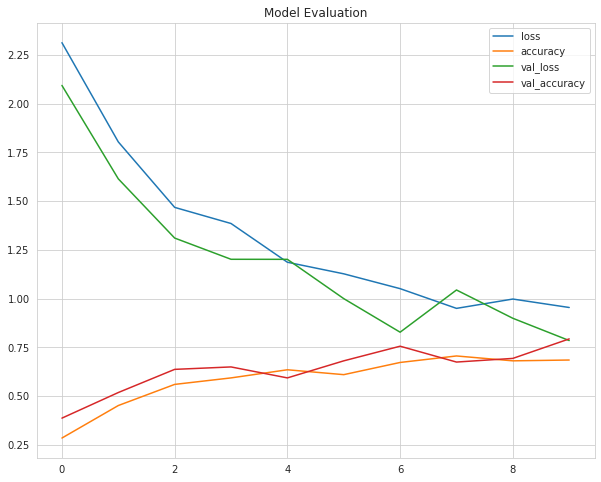

In [15]:
evaluation_plot(inc_history.history)